In [1]:
import os
import netCDF4 as nc
import numpy as np
import pandas as pd

import copy

import scipy.io as io
import scipy.stats as stats
from scipy import signal
from scipy.stats import mode
from scipy.linalg import eig
from scipy.interpolate import interp1d

import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from matplotlib import colors, colorbar
%matplotlib inline
from matplotlib.animation import FuncAnimation
import seaborn as sns

from skimage import measure
from skimage.filters import gaussian

from impdar import *

In [3]:
#files on disk
green_image = '../images/nline5.png'
green_mat = '../data/nline5_migtk_cropped.mat'

#load in data
dat = io.loadmat(green_mat)
data = dat['data']

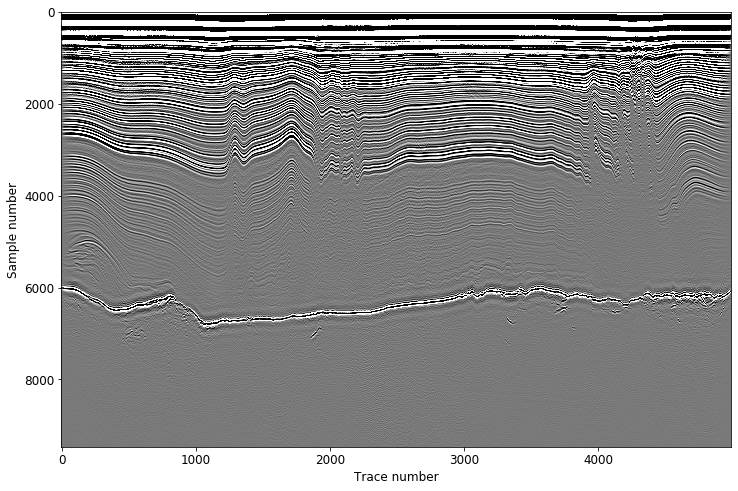

In [4]:
#original image
mini = -8.774235248565674
maxi = 9.667154026031533

fig, ax = plt.subplots(figsize=(12, 8))
p = ax.imshow(data, cmap='gray', aspect='auto', vmin=mini, vmax=maxi, interpolation='nearest')

plt.xlabel('Trace number', fontsize=12)
plt.ylabel('Sample number', fontsize=12)

ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)

### Coherence, Masking

Coherence: $C_{{xy}}(f)={\frac {|G_{{xy}}(f)|^{2}}{G_{{xx}}(f)G_{{yy}}(f)}}$

In [5]:
#create coherence map
sig = 6
gim2 = gaussian(data, sigma=sig)**2
im2g = gaussian(data**2, sigma=sig)
cohere = np.divide(gim2, im2g)

In [6]:
#set threshold value
mask = copy.deepcopy(cohere)
mask[mask<0.5] = 0

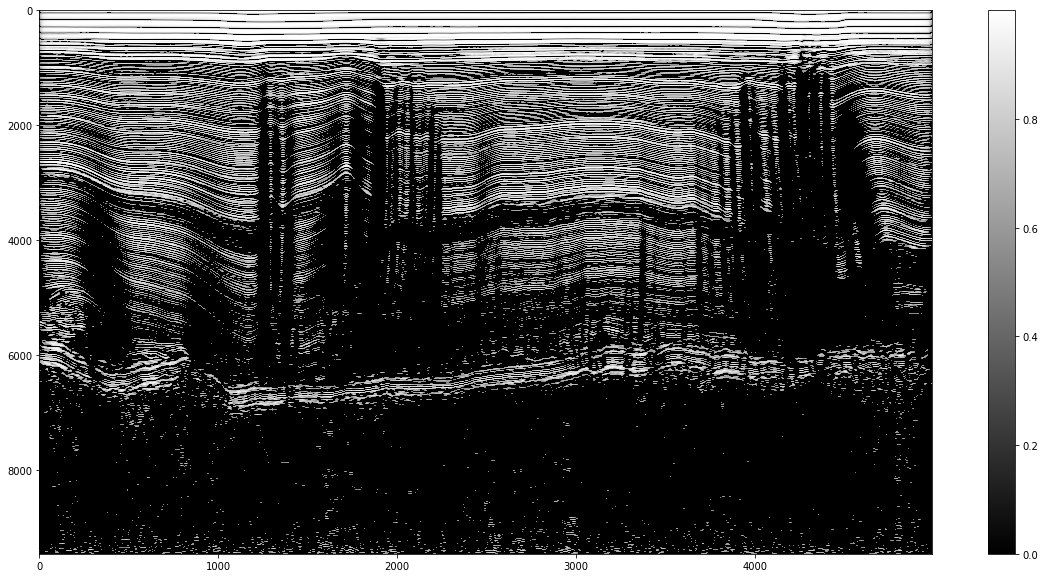

In [7]:
#display thresholded coherence map
fig, ax = plt.subplots(figsize=(20, 10))
p = ax.imshow(mask, cmap='gray', aspect='auto')
fig.colorbar(p)

plt.show()

In [8]:
#do the same thing with a segmented color map
mask2 = copy.deepcopy(cohere)
value = 0.6
masked_array = np.ma.masked_where(mask2 < value, mask2)

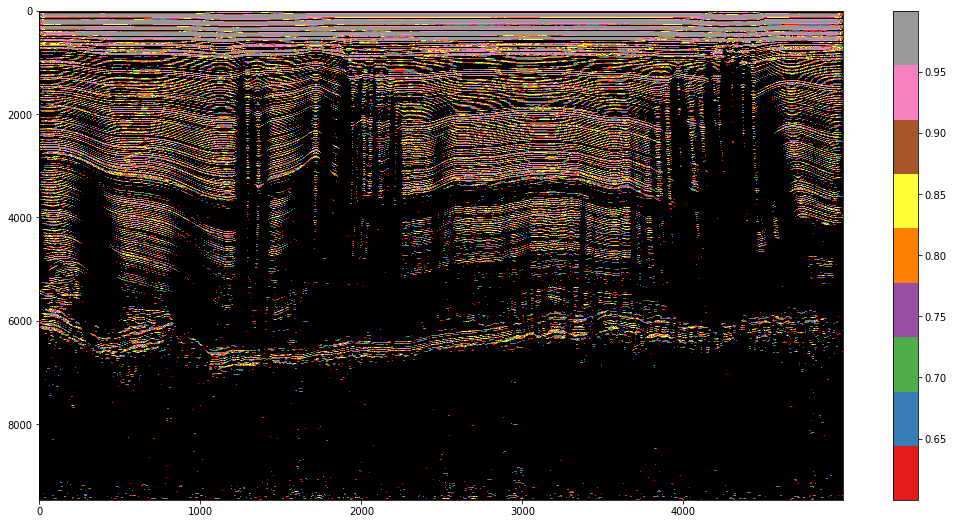

In [9]:
cmap = matplotlib.cm.Set1
cmap.set_bad(color='black')

fig, ax = plt.subplots(figsize=(18, 9))
p = ax.imshow(masked_array, cmap=cmap, aspect='auto')
fig.colorbar(p)

plt.show()

### Contouring

In [10]:
#get positive and negative contours
pos = measure.find_contours(data, 3)
neg = measure.find_contours(data, -3)

In [11]:
#save contours and lengths to lists
c_pos, c_neg, c_length_pos, c_length_neg = [], [], [], []

In [ ]:
#positive contours
for contour in pos:
    c_pos.append(contour)

#negative contours
for contour in neg:
    c_neg.append(contour)
    
#now extract long contours
#this could be done instead of filtering?
for contour in pos:
    c_length_pos.append(len(contour))
    
for contour in neg:
    c_length_neg.append(len(contour))

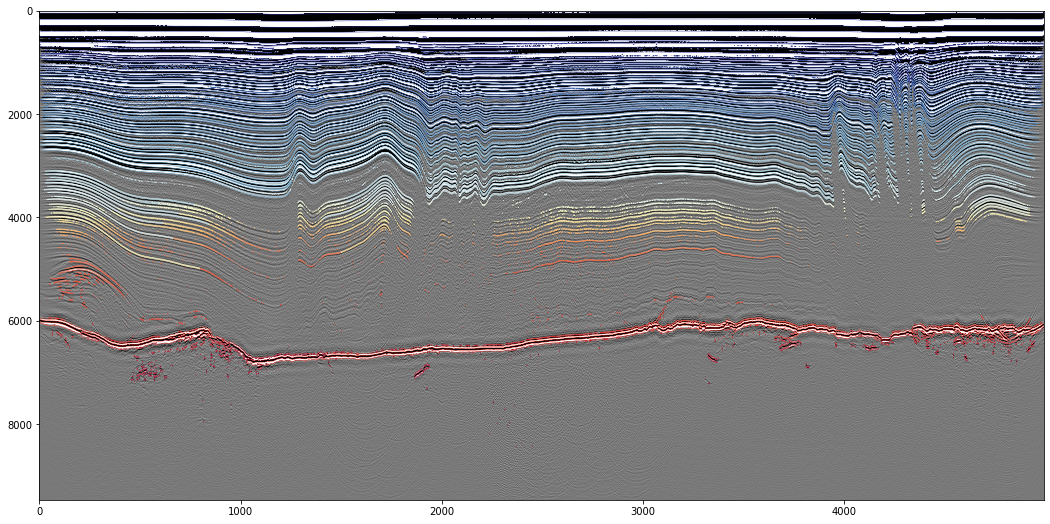

In [12]:
plt.figure(figsize=(18, 9))
plt.imshow(data, cmap='gray', aspect='auto', vmin=mini, vmax=maxi, interpolation='nearest')

for i, contour in enumerate(pos):
    c = cm.RdYlBu_r(i/len(pos))
    plt.plot(contour[:, 1], contour[:, 0], linewidth=0.5, color=c)

plt.show()

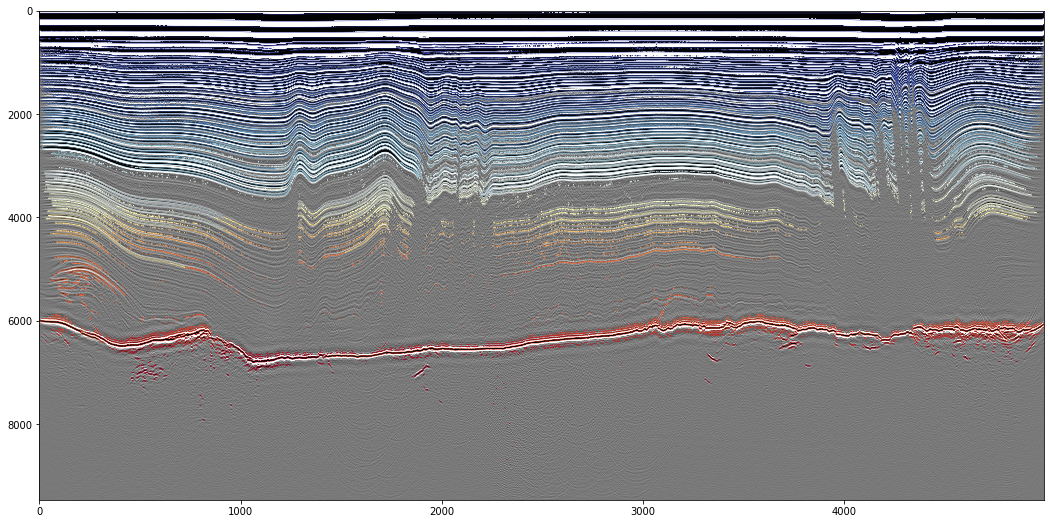

In [13]:
plt.figure(figsize=(18, 9))
plt.imshow(data, cmap='gray', aspect='auto', vmin=mini, vmax=maxi, interpolation='nearest')
    
for i, contour in enumerate(neg):
    c = cm.RdYlBu_r(i/len(neg))
    plt.plot(contour[:, 1], contour[:, 0], linewidth=0.5, color=c)

plt.show()

In [15]:
#find the longest contour
print(np.argmax(c_length_pos))
print(c_length_pos[38])

print(np.argmax(c_length_neg))
print(c_length_neg[298])

#create an iterable list of the contours that are longer than some arbitrary value
long_contours_pos = list(np.where(np.array(c_length_pos) > 500)[0])
long_contours_neg = list(np.where(np.array(c_length_neg) > 500)[0])

38
44400
298
30373


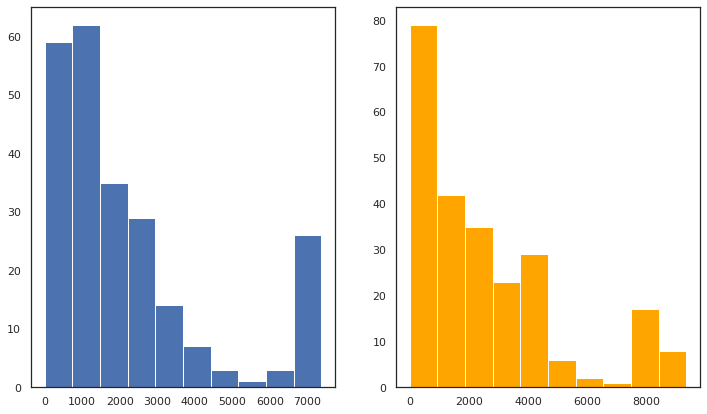

In [16]:
sns.set(style='white')
fig, ax = plt.subplots(1, 2, figsize=(12, 7))
ax[0].hist(long_contours_pos)
ax[1].hist(long_contours_neg, color='orange')

plt.show()

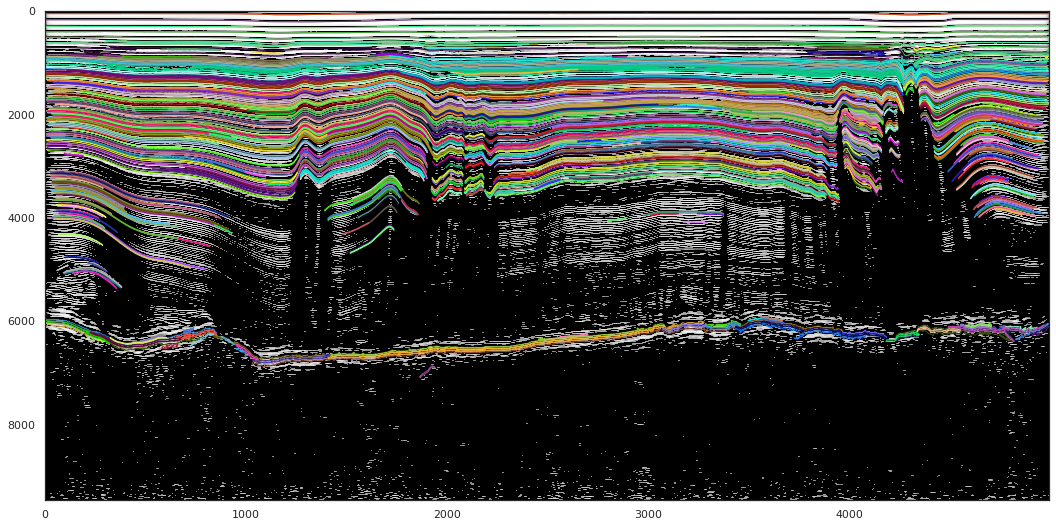

In [17]:
#try to pick out specific contours
fig, ax = plt.subplots(figsize=(18, 9))
ax.imshow(mask, cmap='gray', aspect='auto')

for idx in long_contours_pos:
    ax.plot(pos[idx][:, 1], pos[idx][:, 0], linewidth=1, color=np.random.rand(3,))
    
for idx in long_contours_neg:
    ax.plot(neg[idx][:, 1], neg[idx][:, 0], linewidth=1, color=np.random.rand(3,))
    
plt.show()

# Perhaps everything to do with filtering ends the Notebook, and everything to do with matching is its own?

### Start filtering or matching algorithm here

Basic matchup algorithm:
- if so, somehow compare start and end coordinates, power. Is the power similar or within a given range of the first contour? If not stop. Are the start and end coordinates close? This shouldn't be a be-all-end all mechanism.
- if matching, append indices of second array to first array. We could look at interpolating now, or **leave** that as a postprocessing step.
- Move on to next contour. Once we reach the end of the radargram in length, then append this bigger contour to some contours list, and move on to the next contour.

**Notes**: I need to make sure that contours do not begin at the start before they end.

New algorithm:
- create contours with marching squares
- find ridge
- calculate coherence image
- sort by starting index (x, y) to sort contours by left to right, top to bottom
- match contours by coherence, power, or some other metric

In [19]:
def match_contours(contours, data):
    #set to 0; count changes as you match contours
    changes = 0
    
    #pull out length for contour checking
    height, length = data.shape
    
    #create copy of contours list and a list save matched contours to
    copy_ = copy.deepcopy(contours)
    matches = []
    
    #loop through contours
    for i, contour in enumerate(contours):
        
        #check to see if contour is less than the total length of the radargram
        #this may not work: think about a line going all the way across a profile with severe dips: it would be much longer than 'length'
        #if len(contour)//2 > length:
            #raise Exception('Contour {} is greater than the width of your profile of shape ({},{})'.format(i, height, length))
        #check to see if this contour plus the last contour in copy_ have length > length of the radargram
    
        #coherence check?
        pass
    
    #final check: if changes==0, no more contours to match; exit
    if changes==0:
        return matches